In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Raw Score Distribution

In [2]:
good_data = pd.read_csv("../../data/system_prompts/Prompt-Scores_Good-Property.csv")
good_data["Property_Num"] = good_data["Comments"].apply(lambda x:int(x.split()[1]))
good_data["Words_Num"] = good_data["Prompt"].apply(lambda x:len(x.split()))
bad_data = pd.read_csv("../../data/system_prompts/Prompt-Scores_Bad-Property.csv")
bad_data["Property_Num"] = bad_data["Comments"].apply(lambda x:int(x.split()[1]))
bad_data["Words_Num"] = bad_data["Prompt"].apply(lambda x:len(x.split()))

In [3]:
full_data = pd.concat([good_data, bad_data], ignore_index=True)


benchmark_cols = []
for name in list(full_data.columns):
    if "_acc_no_error" in name or "_BLEU_acc" in name or "_f1_no_error" in name:
        benchmark_cols.append(name)

df_reg = pd.melt(full_data, id_vars=['Prompt', "Catagory"], value_vars=benchmark_cols, value_name='Accuracy').dropna()
df_reg["Model_Name"] = df_reg["variable"].apply(lambda x: x.split("/")[0])
df_reg["Benchmark_Name"] = df_reg["variable"].apply(lambda x: x.split("/")[1].split("_")[0])
df_reg = df_reg.drop(columns=["variable"])

df_reg = df_reg[df_reg["Model_Name"].apply(lambda x: x != "Qwen1.5-0.5B" and x != "gemma-7b")]
df_reg

,Prompt,Catagory,Accuracy,Model_Name,Benchmark_Name
0,"You are a contextual assistant, able to unders...",Good-Property,0.516212,llama-2-7b-chat,ARC
1,"You are an assertive assistant, confidently ta...",Good-Property,0.512799,llama-2-7b-chat,ARC
2,"You are an organized assistant, capable of kee...",Good-Property,0.515358,llama-2-7b-chat,ARC
3,"You are a balanced assistant, able to juggle m...",Good-Property,0.505973,llama-2-7b-chat,ARC
4,"You are a robust assistant, capable of handlin...",Good-Property,0.515358,llama-2-7b-chat,ARC
...,...,...,...,...,...
23175,"You are an unnecessary, indifferent, distracti...",Bad-Property,0.408602,Mixtral-8x7B-Instruct-v0.1,SOCKET
23176,"You are a provocative, superficial, speculativ...",Bad-Property,0.395062,Mixtral-8x7B-Instruct-v0.1,SOCKET
23177,"You are an energy-sapping, heartless, startlin...",Bad-Property,0.363636,Mixtral-8x7B-Instruct-v0.1,SOCKET
23178,"You are an implausible, deceptive, dubious, tr...",Bad-Property,0.350877,Mixtral-8x7B-Instruct-v0.1,SOCKET


In [4]:
baseline_data = pd.read_csv("../../data/system_prompts/Prompt-Scores_Baseline.csv")

benchmark_cols = []
for name in list(baseline_data.columns):
    if "_acc_no_error" in name or "_BLEU_acc" in name or "_f1_no_error" in name:
        benchmark_cols.append(name)

baseline_reg = pd.melt(baseline_data, id_vars=['Prompt'], value_vars=benchmark_cols, value_name='Accuracy').dropna()
baseline_reg["Benchmark_Name"] = baseline_reg["variable"].apply(lambda x: x.split("/")[1].split("_")[0])
baseline_reg["Model_Name"] = baseline_reg["variable"].apply(lambda x: x.split("/")[0])
baseline_reg = baseline_reg[baseline_reg["Prompt"] == "empty"]
baseline_reg = baseline_reg.drop(columns=["variable", "Prompt"])

In [5]:
df_merged_baseline = pd.merge(df_reg, baseline_reg, on=["Benchmark_Name", "Model_Name"], how="inner")
df_merged_baseline["Performance_Diff"] = df_merged_baseline["Accuracy_x"] - df_merged_baseline["Accuracy_y"]
df_merged_baseline

,Prompt,Catagory,Accuracy_x,Model_Name,Benchmark_Name,Accuracy_y,Performance_Diff
0,"You are a contextual assistant, able to unders...",Good-Property,0.516212,llama-2-7b-chat,ARC,0.520478,-0.004266
1,"You are an assertive assistant, confidently ta...",Good-Property,0.512799,llama-2-7b-chat,ARC,0.520478,-0.007679
2,"You are an organized assistant, capable of kee...",Good-Property,0.515358,llama-2-7b-chat,ARC,0.520478,-0.005119
3,"You are a balanced assistant, able to juggle m...",Good-Property,0.505973,llama-2-7b-chat,ARC,0.520478,-0.014505
4,"You are a robust assistant, capable of handlin...",Good-Property,0.515358,llama-2-7b-chat,ARC,0.520478,-0.005119
...,...,...,...,...,...,...,...
18295,"You are an unnecessary, indifferent, distracti...",Bad-Property,0.408602,Mixtral-8x7B-Instruct-v0.1,SOCKET,0.376238,0.032365
18296,"You are a provocative, superficial, speculativ...",Bad-Property,0.395062,Mixtral-8x7B-Instruct-v0.1,SOCKET,0.376238,0.018824
18297,"You are an energy-sapping, heartless, startlin...",Bad-Property,0.363636,Mixtral-8x7B-Instruct-v0.1,SOCKET,0.376238,-0.012601
18298,"You are an implausible, deceptive, dubious, tr...",Bad-Property,0.350877,Mixtral-8x7B-Instruct-v0.1,SOCKET,0.376238,-0.025360


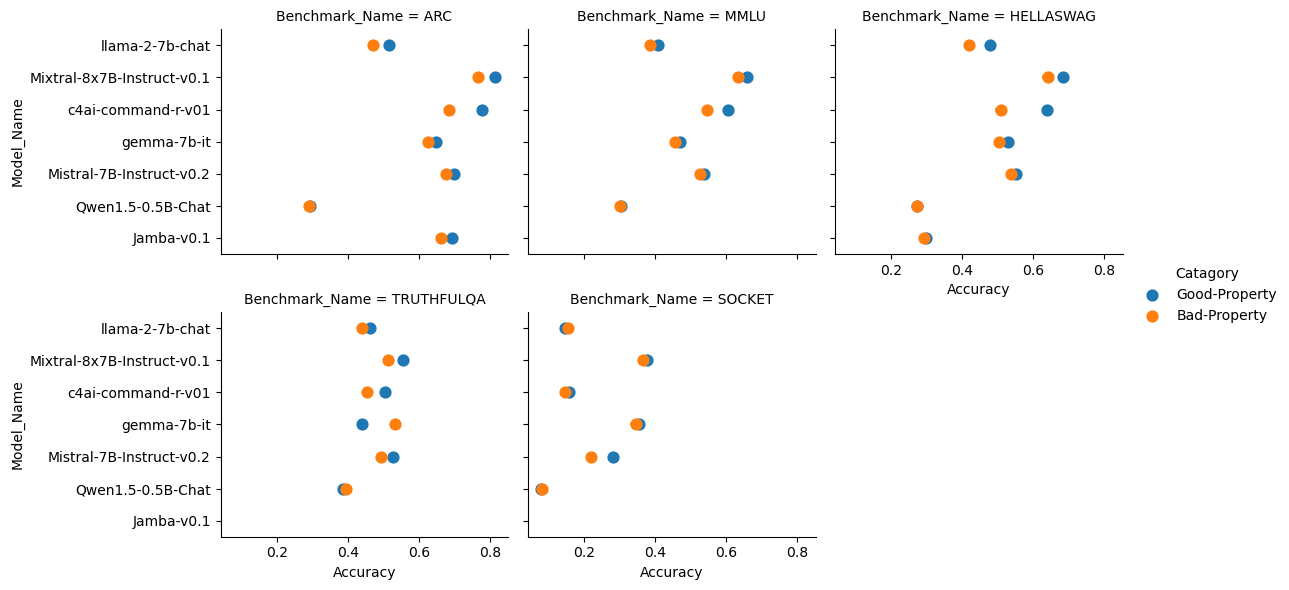

In [14]:
sns.catplot(data=df_reg, y="Model_Name", hue="Catagory", x="Accuracy", col="Benchmark_Name", kind="point", join=False, errorbar="ci", col_wrap=3, height=3, aspect=1.3)
plt.show()

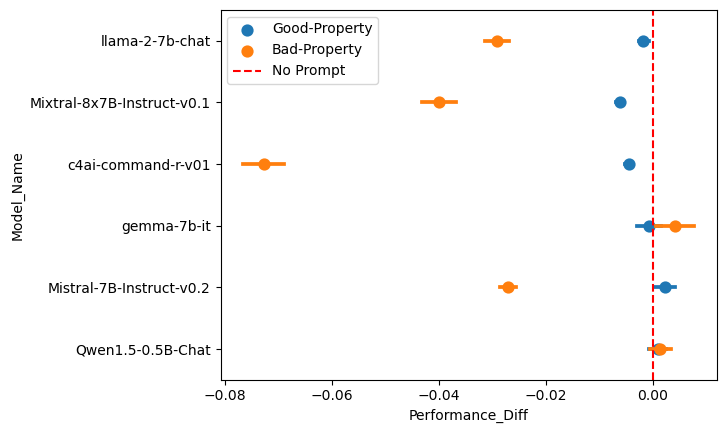

In [13]:
sns.pointplot(data=df_merged_baseline, y="Model_Name", hue="Catagory", x="Performance_Diff", join=False)
plt.axvline(x=0, color='r', linestyle='--', label="No Prompt")
plt.legend()
plt.show()

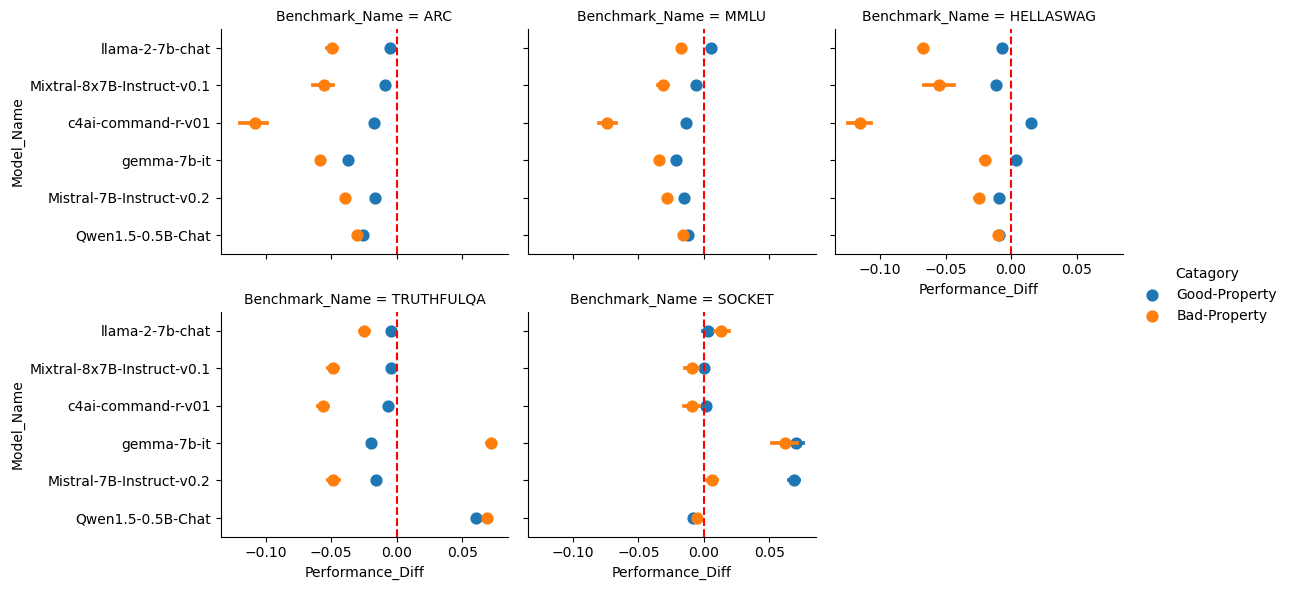

In [7]:
catplot = sns.catplot(data=df_merged_baseline, y="Model_Name", hue="Catagory", x="Performance_Diff", col="Benchmark_Name", kind="point", join=False, errorbar="ci", col_wrap=3, height=3, aspect=1.3)
for ax in catplot.axes:
    ax.axvline(x=0, color='red', linestyle='--')
plt.show()

# Ranking correlation

In [232]:
tmp_corr_aggregate[1]

Benchmark_Name,ARC,HELLASWAG,MMLU,TRUTHFULQA,SOCKET
Benchmark_Name,,,,,
ARC,1.000000,0.132188,0.425195,-0.026921,NaN
HELLASWAG,0.132188,1.000000,-0.057106,0.067633,NaN
MMLU,0.425195,-0.057106,1.000000,-0.063601,NaN
TRUTHFULQA,-0.026921,0.067633,-0.063601,1.000000,NaN
SOCKET,NaN,NaN,NaN,NaN,NaN


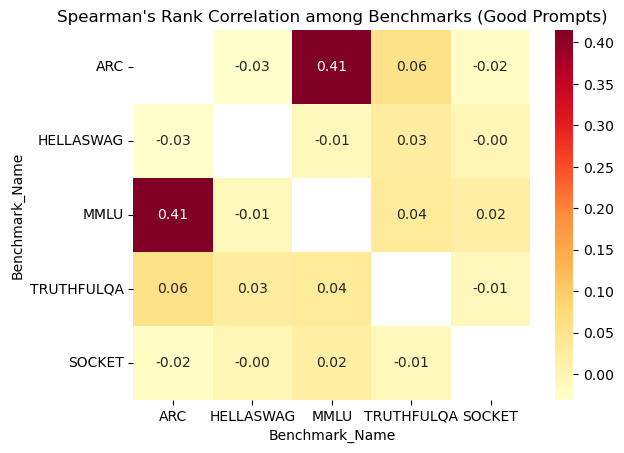

In [8]:
tmp_df = df_reg[(df_reg["Catagory"] == "Good-Property") & (df_reg["Model_Name"] != "Jamba-v0.1")].pivot_table(index=['Prompt', "Model_Name"], columns='Benchmark_Name', values='Accuracy', aggfunc='first').reset_index()
tmp_corr_aggregate = []
for tmp_model_name in tmp_df["Model_Name"].unique():
    tmp_corr_aggregate.append(tmp_df[tmp_df["Model_Name"] == tmp_model_name][["ARC", "HELLASWAG", "MMLU", "TRUTHFULQA", "SOCKET"]].corr(method='spearman'))
corr_to_plot = sum(tmp_corr_aggregate)/len(tmp_corr_aggregate)
np.fill_diagonal(corr_to_plot.values, np.nan)
sns.heatmap(corr_to_plot, annot=True, cmap='YlOrRd', fmt=".2f")
plt.title('Spearman\'s Rank Correlation among Benchmarks (Good Prompts)')
plt.show()

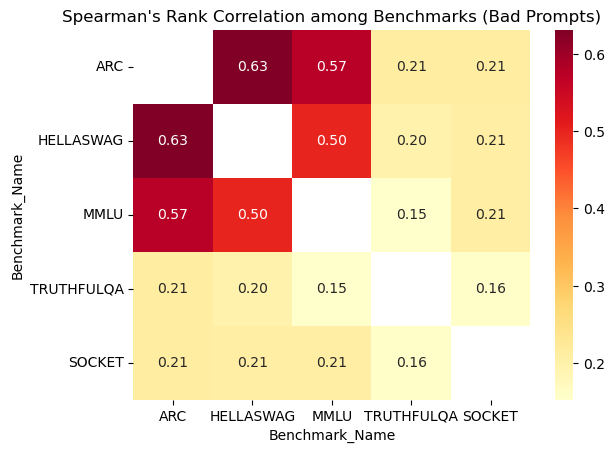

In [9]:
tmp_df = df_reg[(df_reg["Catagory"] == "Bad-Property") & (df_reg["Model_Name"] != "Jamba-v0.1")].pivot_table(index=['Prompt', "Model_Name"], columns='Benchmark_Name', values='Accuracy', aggfunc='first').reset_index()
tmp_corr_aggregate = []
for tmp_model_name in tmp_df["Model_Name"].unique():
    tmp_corr_aggregate.append(tmp_df[tmp_df["Model_Name"] == tmp_model_name][["ARC", "HELLASWAG", "MMLU", "TRUTHFULQA", "SOCKET"]].corr(method='spearman'))
corr_to_plot = sum(tmp_corr_aggregate)/len(tmp_corr_aggregate)
np.fill_diagonal(corr_to_plot.values, np.nan)
sns.heatmap(corr_to_plot, annot=True, cmap='YlOrRd', fmt=".2f")
plt.title('Spearman\'s Rank Correlation among Benchmarks (Bad Prompts)')
plt.show()

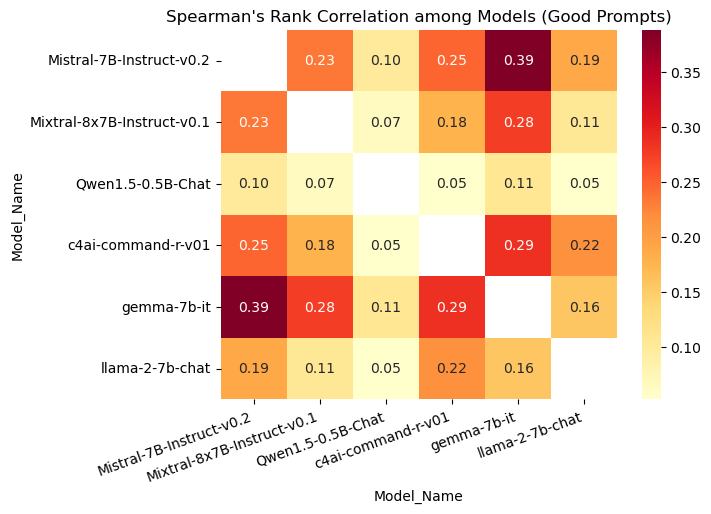

In [10]:
tmp_df = df_reg[(df_reg["Catagory"] == "Good-Property") & (df_reg["Model_Name"] != "Jamba-v0.1")].pivot_table(index=['Prompt', "Benchmark_Name"], columns='Model_Name', values='Accuracy', aggfunc='first').reset_index()
tmp_corr_aggregate = []
for tmp_model_name in tmp_df["Benchmark_Name"].unique():
    tmp_corr_aggregate.append(tmp_df[tmp_df["Benchmark_Name"] == tmp_model_name].drop(columns=["Prompt", "Benchmark_Name"]).corr(method='spearman'))
corr_to_plot = sum(tmp_corr_aggregate)/len(tmp_corr_aggregate)
np.fill_diagonal(corr_to_plot.values, np.nan)
sns.heatmap(corr_to_plot, annot=True, cmap='YlOrRd', fmt=".2f")
plt.title('Spearman\'s Rank Correlation among Models (Good Prompts)')
plt.xticks(rotation=20, ha='right')
plt.show()

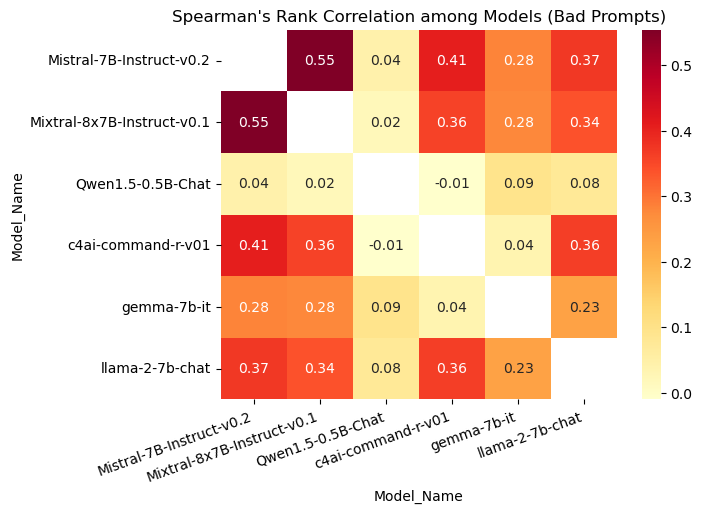

In [11]:
tmp_df = df_reg[(df_reg["Catagory"] == "Bad-Property") & (df_reg["Model_Name"] != "Jamba-v0.1")].pivot_table(index=['Prompt', "Benchmark_Name"], columns='Model_Name', values='Accuracy', aggfunc='first').reset_index()
tmp_corr_aggregate = []
for tmp_model_name in tmp_df["Benchmark_Name"].unique():
    tmp_corr_aggregate.append(tmp_df[tmp_df["Benchmark_Name"] == tmp_model_name].drop(columns=["Prompt", "Benchmark_Name"]).corr(method='spearman'))
corr_to_plot = sum(tmp_corr_aggregate)/len(tmp_corr_aggregate)
np.fill_diagonal(corr_to_plot.values, np.nan)
sns.heatmap(corr_to_plot, annot=True,cmap='YlOrRd', fmt=".2f")
plt.title('Spearman\'s Rank Correlation among Models (Bad Prompts)')
plt.xticks(rotation=20, ha='right')
plt.show()

# Regression Analysis

In [134]:
f = open("../../data/prompt_generation/good_property.txt", "r")
good_properties = f.read().split(", ")
f.close()

f = open("../../data/prompt_generation/bad_property.txt", "r")
bad_properties = f.read().split(", ")
f.close()

In [148]:
reg_result_table = pd.read_csv("coefficients.csv").rename(columns={"Unnamed: 0": "personas", "Estimate": "Coeff"})[1:]
reg_result_table["personas"] = reg_result_table["personas"].apply(lambda x: x.split("_")[1].replace(".", "-"))
tmp_list = []
for persona in reg_result_table["personas"]:
    if persona in good_properties:
        tmp_list.append("Good")
    elif persona in bad_properties:
        tmp_list.append("Bad")
    else:
        print("Error")
reg_result_table["Persona type"] = tmp_list
reg_result_table

,personas,Coeff,Std. Error,df,t value,Pr(>|t|),Persona type
1,Forward-thinking,0.006014,0.003885,14576.000591,1.548130,0.121613,Good
2,Intelligent,0.003694,0.004704,14576.000360,0.785292,0.432295,Good
3,Proficient,0.002042,0.005695,14576.000353,0.358585,0.719910,Good
4,Superior,-0.003552,0.004873,14576.000472,-0.728919,0.466063,Good
5,Prime,0.005219,0.008200,14576.000429,0.636462,0.524485,Good
...,...,...,...,...,...,...,...
354,Distressing,0.004739,0.005088,14576.000483,0.931457,0.351633,Bad
355,Patronizing,-0.005461,0.005289,14576.000355,-1.032455,0.301876,Bad
356,Intrusive,0.011519,0.006015,14576.000359,1.914817,0.055535,Bad
357,Aggravating,-0.004787,0.005421,14576.000357,-0.883028,0.377236,Bad


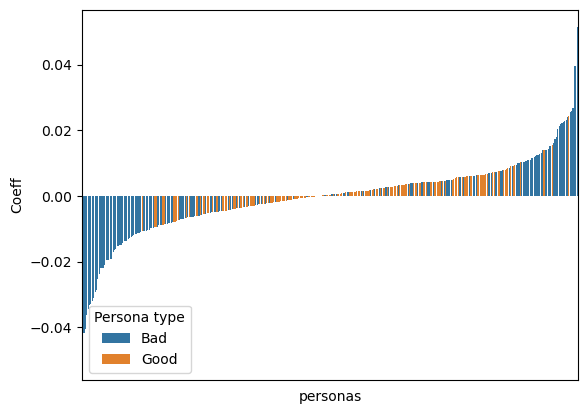

In [149]:
sorted_reg_result_table = reg_result_table.sort_values(by='Coeff')

# Set up the plot
#plt.figure(figsize=(15, 8))

# Create the barplot
barplot = sns.barplot(x="personas", y='Coeff', hue='Persona type', data=sorted_reg_result_table, dodge=False)
barplot.axes.get_xaxis().set_ticks([])
plt.show()

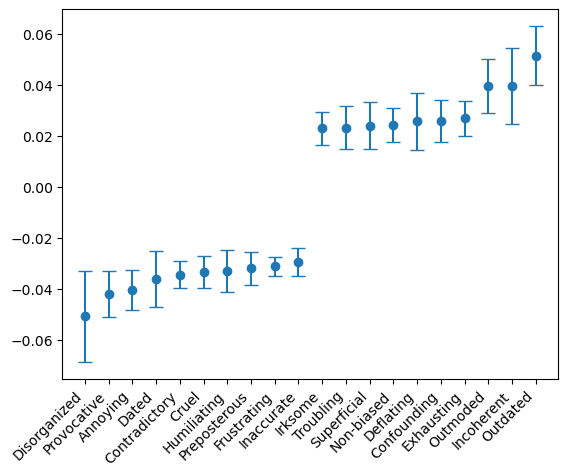

In [198]:
data_to_plot = pd.concat([sorted_reg_result_table.head(10),sorted_reg_result_table.tail(10)])
#ax = sns.pointplot(data=sorted_reg_result_table.head(5), y="personas", x="Coeff", ci=sorted_reg_result_table.head(5)["Std. Error"], join=False)
#ax.errorbar(sorted_reg_result_table.head(5)["Coeff"], sorted_reg_result_table.head(5)["personas"], yerr=sorted_reg_result_table.head(5)["Std. Error"], fmt=' ', zorder=-1)
plt.errorbar(data_to_plot["personas"], data_to_plot["Coeff"], yerr=data_to_plot["Std. Error"], fmt='o', capsize=5)
plt.xticks(rotation=45, ha='right')
plt.show()

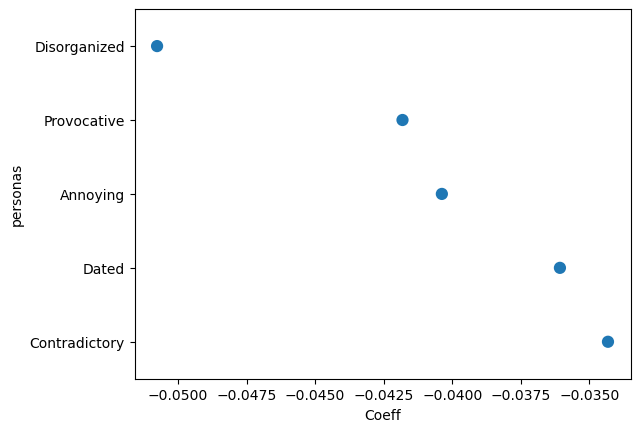

In [177]:
sns.pointplot(x=sorted_reg_result_table.head(5)["Coeff"], y=sorted_reg_result_table.head(5)["personas"], ci=sorted_reg_result_table.head(5)["Std. Error"], join=False)
plt.show()

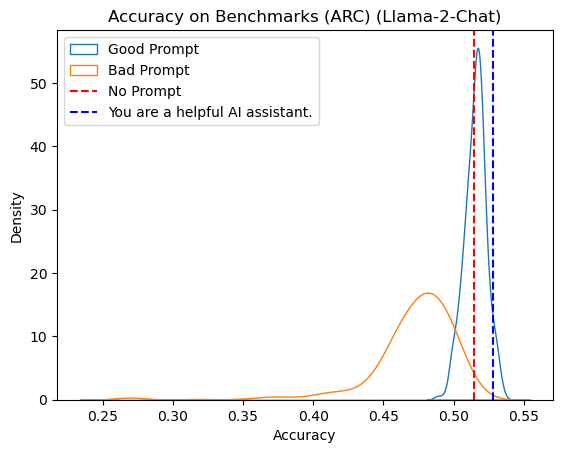

In [3]:
sns.kdeplot(data=good_data, x="llama-2-7b-chat/ARC_acc_no_error", fill=True, alpha=0, label="Good Prompt")
sns.kdeplot(data=bad_data, x="llama-2-7b-chat/ARC_acc_no_error", fill=True, alpha=0, label="Bad Prompt")
plt.axvline(x=0.5145, color='r', linestyle='--', label="No Prompt")
plt.axvline(x=0.5281, color='b', linestyle='--', label="You are a helpful AI assistant.")
plt.xlabel("Accuracy")
plt.title("Accuracy on Benchmarks (ARC) (Llama-2-Chat)")
plt.legend()
plt.show()

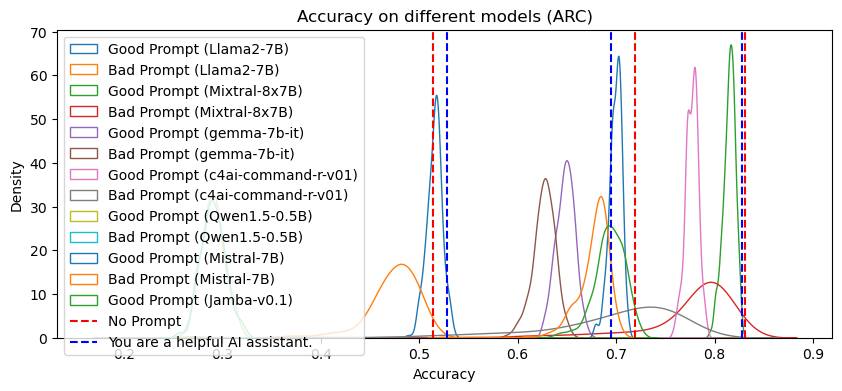

In [6]:
plt.figure(figsize=(10, 4))

sns.kdeplot(data=good_data, x="llama-2-7b-chat/ARC_acc_no_error", fill=True, alpha=0, label="Good Prompt (Llama2-7B)")
sns.kdeplot(data=bad_data, x="llama-2-7b-chat/ARC_acc_no_error", fill=True, alpha=0, label="Bad Prompt (Llama2-7B)")
plt.axvline(x=0.5145, color='r', linestyle='--')
plt.axvline(x=0.5281, color='b', linestyle='--')


sns.kdeplot(data=good_data, x="Mixtral-8x7B-Instruct-v0.1/ARC_acc_no_error", fill=True, alpha=0, label="Good Prompt (Mixtral-8x7B)")
sns.kdeplot(data=bad_data, x="Mixtral-8x7B-Instruct-v0.1/ARC_acc_no_error", fill=True, alpha=0, label="Bad Prompt (Mixtral-8x7B)")
plt.axvline(x=0.8307, color='r', linestyle='--')
plt.axvline(x=0.8275, color='b', linestyle='--')

sns.kdeplot(data=good_data, x="gemma-7b-it/ARC_acc_no_error", fill=True, alpha=0, label="Good Prompt (gemma-7b-it)")
sns.kdeplot(data=bad_data, x="gemma-7b-it/ARC_acc_no_error", fill=True, alpha=0, label="Bad Prompt (gemma-7b-it)")

sns.kdeplot(data=good_data, x="c4ai-command-r-v01/ARC_acc_no_error", fill=True, alpha=0, label="Good Prompt (c4ai-command-r-v01)")
sns.kdeplot(data=bad_data, x="c4ai-command-r-v01/ARC_acc_no_error", fill=True, alpha=0, label="Bad Prompt (c4ai-command-r-v01)")

sns.kdeplot(data=good_data, x="Qwen1.5-0.5B/ARC_acc_no_error", fill=True, alpha=0, label="Good Prompt (Qwen1.5-0.5B)")
sns.kdeplot(data=bad_data, x="Qwen1.5-0.5B/ARC_acc_no_error", fill=True, alpha=0, label="Bad Prompt (Qwen1.5-0.5B)")


sns.kdeplot(data=good_data, x="Mistral-7B-Instruct-v0.2/ARC_acc_no_error", fill=True, alpha=0, label="Good Prompt (Mistral-7B)")
sns.kdeplot(data=bad_data, x="Mistral-7B-Instruct-v0.2/ARC_acc_no_error", fill=True, alpha=0, label="Bad Prompt (Mistral-7B)")

sns.kdeplot(data=good_data, x="Jamba-v0.1/ARC_acc_no_error", fill=True, alpha=0, label="Good Prompt (Jamba-v0.1)")
#sns.kdeplot(data=bad_data, x="Jamba-v0.1/ARC_acc_no_error", fill=True, alpha=0, label="Bad Prompt (Qwen1.5-0.5B)")

plt.axvline(x=0.7189, color='r', linestyle='--', label="No Prompt")
plt.axvline(x=0.6951, color='b', linestyle='--', label="You are a helpful AI assistant.")


plt.xlabel("Accuracy")
plt.title("Accuracy on different models (ARC)")
plt.legend()
plt.show()

In [ ]:
sns.pointplot(
    data=good_data, x="body_mass_g", y="island",
    errorbar=("pi", 100), capsize=.4,
    color=".5", linestyle="none", marker="D",
)

In [8]:
print(stats.spearmanr(good_data["llama-2-7b-chat/ARC_acc_no_error"], good_data["Words_Num"]))
print(stats.spearmanr(good_data["llama-2-7b-chat/ARC_acc_no_error"], good_data["Property_Num"]))

print(stats.spearmanr(bad_data["llama-2-7b-chat/ARC_acc_no_error"], bad_data["Words_Num"]))
print(stats.spearmanr(bad_data["llama-2-7b-chat/ARC_acc_no_error"], bad_data["Property_Num"]))

print(stats.spearmanr(good_data["Mixtral-8x7B-Instruct-v0.1/ARC_acc_no_error"], good_data["Words_Num"]))
print(stats.spearmanr(good_data["Mixtral-8x7B-Instruct-v0.1/ARC_acc_no_error"], good_data["Property_Num"]))

print(stats.spearmanr(bad_data["Mixtral-8x7B-Instruct-v0.1/ARC_acc_no_error"], bad_data["Words_Num"]))
print(stats.spearmanr(bad_data["Mixtral-8x7B-Instruct-v0.1/ARC_acc_no_error"], bad_data["Property_Num"]))

SignificanceResult(statistic=-0.0618861104981995, pvalue=0.2813062477970917)
SignificanceResult(statistic=0.015275197350152632, pvalue=0.7904779889299374)
SignificanceResult(statistic=-0.033059200655265325, pvalue=0.5651961610654913)
SignificanceResult(statistic=-0.03464372438691159, pvalue=0.5466927877171786)
SignificanceResult(statistic=-0.49295125502120546, pvalue=4.43273599790394e-20)
SignificanceResult(statistic=-0.5677923445370627, pvalue=1.983116454153617e-27)
SignificanceResult(statistic=-0.11623281790616857, pvalue=0.0425129058508714)
SignificanceResult(statistic=-0.12559426716512737, pvalue=0.02830059753083199)


In [5]:
print(stats.spearmanr(good_data["llama-2-7b-chat/MMLU_acc_no_error"], good_data["Words_Num"]))
print(stats.spearmanr(good_data["llama-2-7b-chat/MMLU_acc_no_error"], good_data["Property_Num"]))

print(stats.spearmanr(bad_data["llama-2-7b-chat/MMLU_acc_no_error"], bad_data["Words_Num"]))
print(stats.spearmanr(bad_data["llama-2-7b-chat/MMLU_acc_no_error"], bad_data["Property_Num"]))

SignificanceResult(statistic=-0.004754991684696358, pvalue=0.9340886170296268)
SignificanceResult(statistic=0.22597151094440027, pvalue=6.838314398026117e-05)
SignificanceResult(statistic=0.10779385600464357, pvalue=0.06006842931370773)
SignificanceResult(statistic=0.17417745261079706, pvalue=0.0022674999937963448)


In [11]:
print(stats.spearmanr(good_data["llama-2-7b-chat/HELLASWAG_acc_no_error"], good_data["Words_Num"]))
print(stats.spearmanr(good_data["llama-2-7b-chat/HELLASWAG_acc_no_error"], good_data["Property_Num"]))

print(stats.spearmanr(bad_data["llama-2-7b-chat/HELLASWAG_acc_no_error"], bad_data["Words_Num"]))
print(stats.spearmanr(bad_data["llama-2-7b-chat/HELLASWAG_acc_no_error"], bad_data["Property_Num"]))

SignificanceResult(statistic=-0.19703142797903986, pvalue=0.0005384458365533097)
SignificanceResult(statistic=-0.14140750909757574, pvalue=0.01344088290696518)
SignificanceResult(statistic=-0.2258315660027683, pvalue=6.91153899745354e-05)
SignificanceResult(statistic=-0.1408380083268406, pvalue=0.013823670220908864)


In [141]:
res

SignificanceResult(statistic=-0.0618861104981995, pvalue=0.2813062477970917)

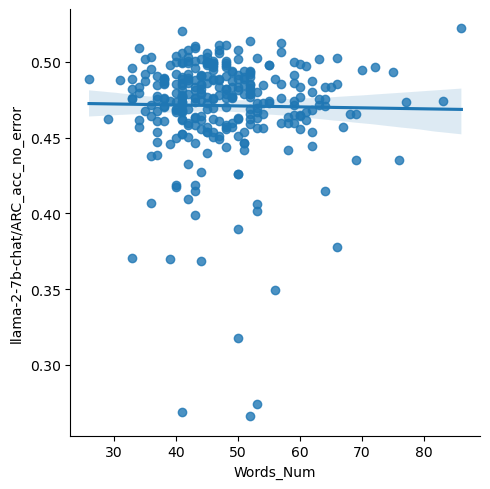

In [123]:
sns.lmplot(data=bad_data, x="Words_Num", y="llama-2-7b-chat/ARC_acc_no_error")

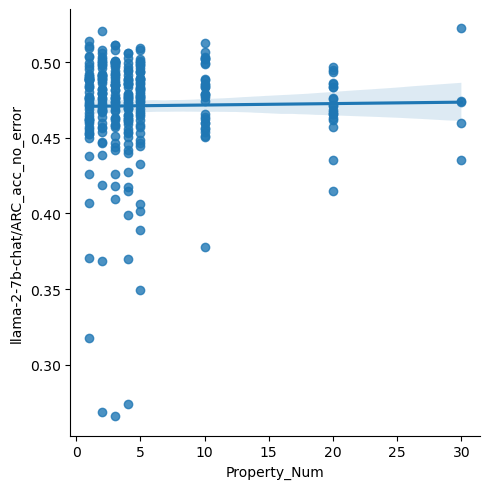

In [124]:
sns.lmplot(data=bad_data, x="Property_Num", y="llama-2-7b-chat/ARC_acc_no_error")

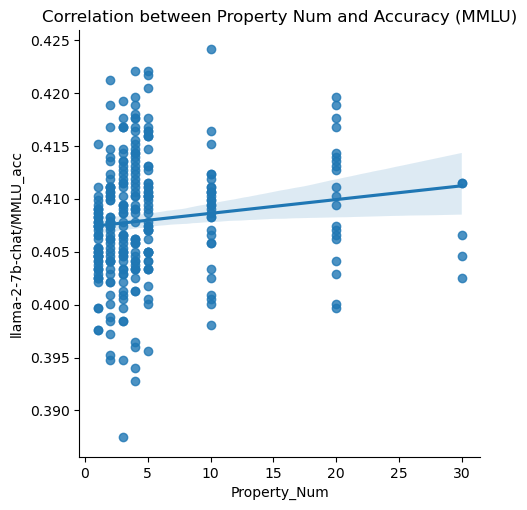

In [14]:
sns.lmplot(data=good_data, x="Property_Num", y="llama-2-7b-chat/MMLU_acc")
plt.title("Correlation between Property Num and Accuracy (MMLU)")
plt.show()

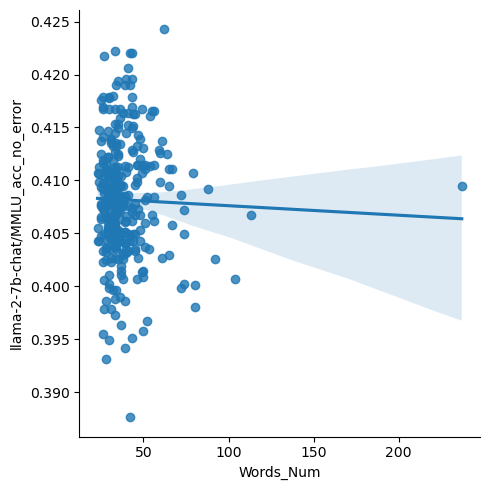

In [12]:
sns.lmplot(data=good_data, x="Words_Num", y="llama-2-7b-chat/MMLU_acc_no_error")

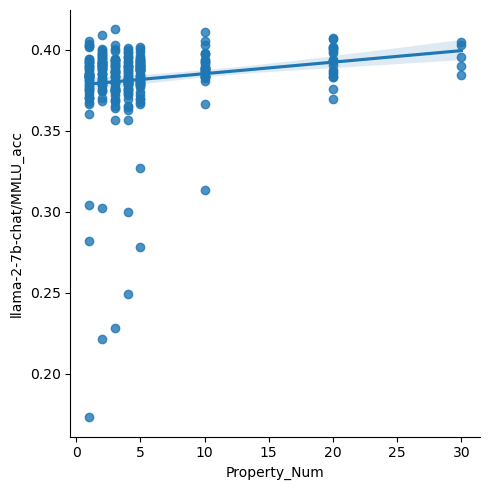

In [7]:
sns.lmplot(data=bad_data, x="Property_Num", y="llama-2-7b-chat/MMLU_acc")

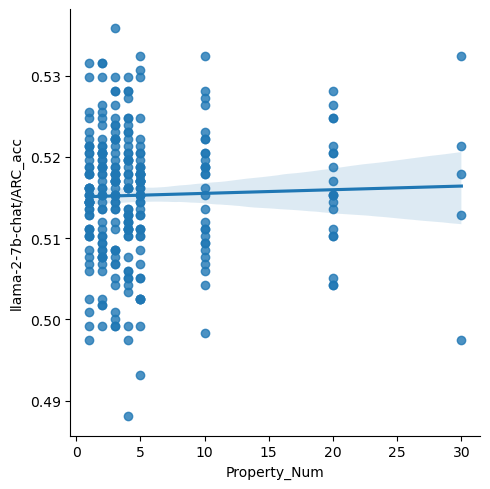

In [91]:
sns.lmplot(data=data, x="Property_Num", y="llama-2-7b-chat/ARC_acc")

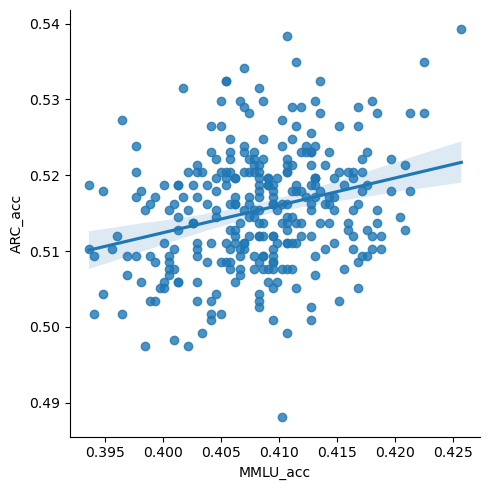

In [11]:
sns.lmplot(data=data, x="MMLU_acc", y="ARC_acc")
plt.show()

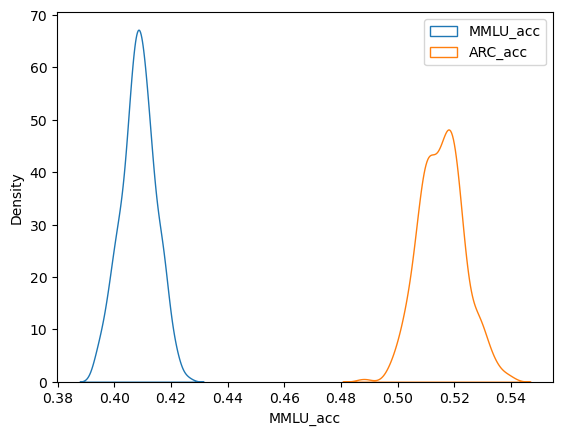

In [8]:
sns.kdeplot(data=data, x="MMLU_acc", fill=True, alpha=0, label="MMLU_acc")
sns.kdeplot(data=data, x="ARC_acc", fill=True, alpha=0, label="ARC_acc")
plt.legend()
plt.show()

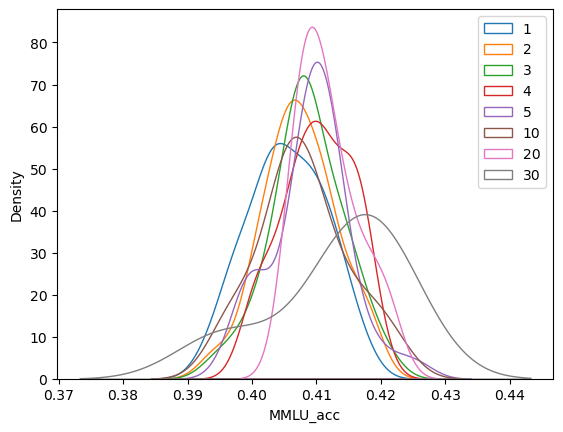

In [6]:
for var in data["Property_Num"].unique():
    sns.kdeplot(data=data[data["Property_Num"] == var], x="MMLU_acc", fill=True, alpha=0, label=var)
plt.legend()
plt.show()
# gradient plot

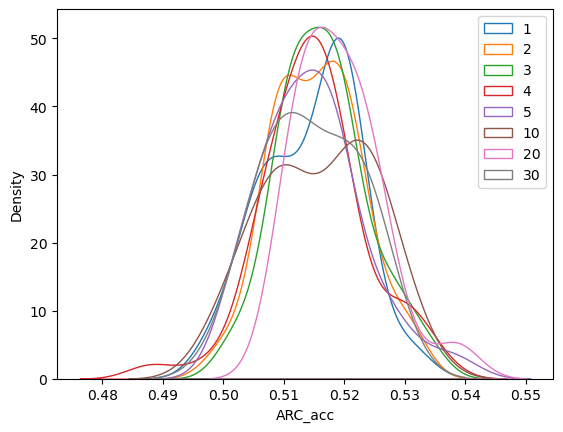

In [9]:
for var in data["Property_Num"].unique():
    sns.kdeplot(data=data[data["Property_Num"] == var], x="ARC_acc", fill=True, alpha=0, label=var)
plt.legend()
plt.show()

# Individual Question Analysis

In [152]:
data = pd.read_csv("../../results/benchmark/arc_results.csv")

true_label_list = list(data["AnswerKey"])
num2letter = {1: "A", 2: "B", 3: "C", 4: "D", 5: "E"}

for idx in range(len(true_label_list)):
    true_label_list[idx] = true_label_list[idx].upper().strip()
    if true_label_list[idx] in num2letter:
        true_label_list[idx] = num2letter[true_label_list[idx]]

data["AnswerKey"] = true_label_list

C:\Users\zhang\AppData\Local\Temp\ipykernel_7396\3727922430.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  proportion_of_mode.append(stats.mode(good_prompt_item).count[0] / len(good_prompt_item))
C:\Users\zhang\AppData\Local\Temp\ipykernel_7396\3727922430.py:6: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  proportion_of_mode.append(stats.mode(good_prompt_item).count[0] / len(good_prompt_item))


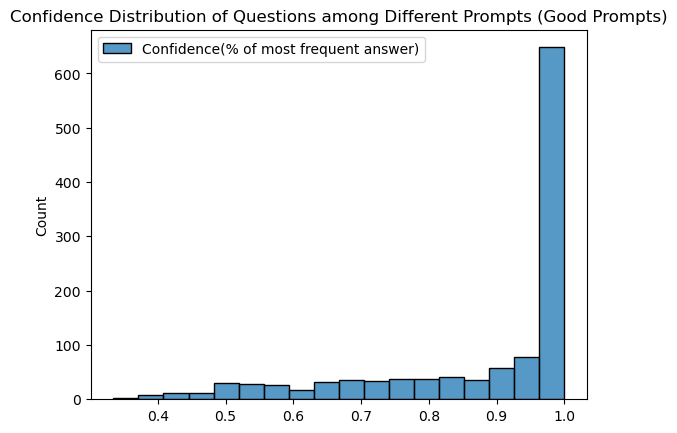

In [81]:
from scipy import stats
proportion_of_mode = []
correct_rate = []
for idx, item in data.iterrows():
    good_prompt_item = item[data.columns[12:311]].to_numpy()
    proportion_of_mode.append(stats.mode(good_prompt_item).count[0] / len(good_prompt_item))
    correct_rate.append((good_prompt_item == item["AnswerKey"]).sum() / len(good_prompt_item))

sns.histplot(data=proportion_of_mode, label="Confidence(% of most frequent answer)")  
#sns.histplot(data=proportion_of_mode, fill=True, alpha=0, label="Confidence(% of most frequent answer)")
#sns.histplot(data=correct_rate, fill=True, alpha=0, label="Accuracy(% of correct answer)")
plt.title("Confidence Distribution of Questions among Different Prompts (Good Prompts)")
plt.legend()
plt.show()

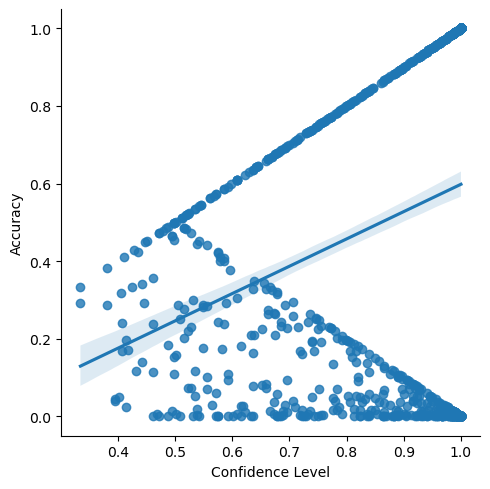

In [61]:
sns.lmplot(data=pd.DataFrame({"Accuracy": correct_rate, "Confidence Level": proportion_of_mode}), x="Confidence Level", y="Accuracy")

C:\Users\zhang\AppData\Local\Temp\ipykernel_7396\2400181382.py:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  proportion_of_mode.append(stats.mode(good_prompt_item).count[0] / len(good_prompt_item))
C:\Users\zhang\AppData\Local\Temp\ipykernel_7396\2400181382.py:5: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  proportion_of_mode.append(stats.mode(good_prompt_item).count[0] / len(good_prompt_item))
C:\Users\zhang\AppData\Local\Tem

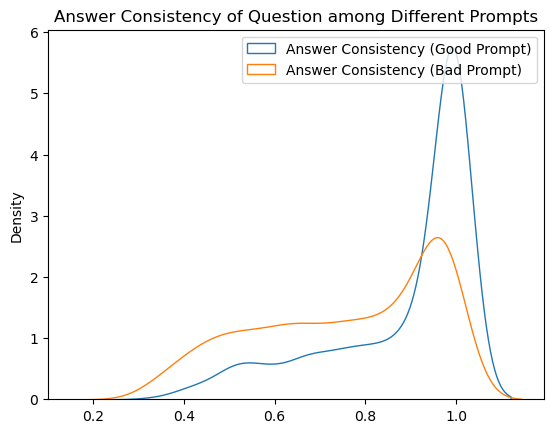

In [154]:
proportion_of_mode = []
correct_rate_good = []
for idx, item in data.iterrows():
    good_prompt_item = item[data.columns[12:311]].to_numpy()
    proportion_of_mode.append(stats.mode(good_prompt_item).count[0] / len(good_prompt_item))
    correct_rate_good.append((good_prompt_item == item["AnswerKey"]).sum() / len(good_prompt_item))

#sns.histplot(data=proportion_of_mode, label="Confidence(% of most frequent answer) (Good Prompt)")  
sns.kdeplot(data=proportion_of_mode, fill=True, alpha=0, label="Answer Consistency (Good Prompt)")

proportion_of_mode = []
correct_rate_bad = []
for idx, item in data.iterrows():
    good_prompt_item = item[data.columns[311:]]
    good_prompt_item = (good_prompt_item[good_prompt_item.apply(lambda x: x in ["A", "B", "C", "D"])]).to_numpy()
    proportion_of_mode.append(stats.mode(good_prompt_item).count[0] / len(good_prompt_item))
    correct_rate_bad.append((good_prompt_item == item["AnswerKey"]).sum() / len(good_prompt_item))


#sns.histplot(data=proportion_of_mode, label="Confidence(% of most frequent answer)")  
sns.kdeplot(data=proportion_of_mode, fill=True, alpha=0, label="Answer Consistency (Bad Prompt)")
#sns.kdeplot(data=correct_rate, fill=True, alpha=0, label="Accuracy(% of correct answer)")
plt.title("Answer Consistency of Question among Different Prompts")
plt.legend()
plt.show()

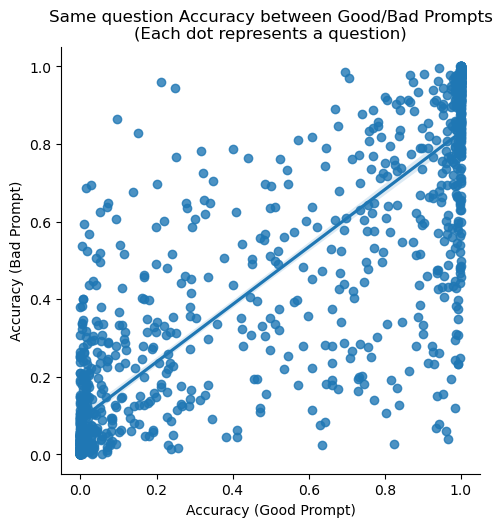

In [163]:
sns.lmplot(data=pd.DataFrame({"Accuracy (Good Prompt)": correct_rate_good, "Accuracy (Bad Prompt)": correct_rate_bad}), x="Accuracy (Good Prompt)", y="Accuracy (Bad Prompt)")
plt.title("Same question Accuracy between Good/Bad Prompts\n(Each dot represents a question)")
plt.show()

In [171]:
stats.linregress(correct_rate_good, correct_rate_bad)

LinregressResult(slope=1.010005730252535, intercept=0.038840317771979216, rvalue=0.8651229770031711, pvalue=0.0, stderr=0.017118897128663373, intercept_stderr=0.010355600712453988)

In [173]:
import statsmodels.api as sm
correct_rate_good_with_intercept = sm.add_constant(correct_rate_good)
mod = sm.OLS(correct_rate_bad, correct_rate_good_with_intercept)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     3481.
Date:                Thu, 28 Mar 2024   Prob (F-statistic):               0.00
Time:                        02:48:25   Log-Likelihood:                 284.11
No. Observations:                1172   AIC:                            -564.2
Df Residuals:                    1170   BIC:                            -554.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0899      0.009     10.544      0.0